<a href="https://colab.research.google.com/github/ahmadpnb/combinationforecast/blob/main/Anis_OLSTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#please install all packages if not available, can use similar code as shown below for installation. Once installed, no need to reinstall
!pip install arch
!pip install linearmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.4 MB/s eta 0:00:00


In [ ]:
#packages needed for this script

import pandas as pd #package for data handling
import numpy as np #package for default arithmetic
import seaborn as sns #package for plotting graph
import matplotlib.pyplot as plt #package for plotting graph
import statsmodels.api as sm #package for models and other statistical test
import linearmodels.iv.model as lm #package for linearmodels for endogeneity test
from statsmodels.stats.diagnostic import het_breuschpagan #package for Breusch Pagan test for heteroscedasticity
from statsmodels.stats.diagnostic import acorr_ljungbox #package for ljungbox test for white noise
from statsmodels.stats.diagnostic import linear_harvey_collier #package for Harvey Collier test for linearity
from statsmodels.stats.diagnostic import linear_lm #package for Lagrange multiplier test for linearity
from statsmodels.stats.outliers_influence import variance_inflation_factor #package for vif to test for multicollinearity
from statsmodels.stats.stattools import jarque_bera # package for jarque bera test of normality
from statsmodels.tools.tools import maybe_unwrap_results #package for regression diagnostics graphics
from statsmodels.graphics.gofplots import ProbPlot #package for regression diagnostics graphics
from statsmodels.tsa.arima.model import ARIMA #package for ARIMA
from typing import Type
from sklearn.model_selection import train_test_split #for train_test
from sklearn.metrics import mean_squared_error #to find mse and rmse

In [ ]:
# Functions for EDA

def eda(df):
  print(df.info())
  print()
  print()
  display(df.head(10), df.tail(10))
  print()
  print()
  print('Data summary statistics')
  display(df.describe())
  print()
  print()
  df.select_dtypes(include = np.number).plot(subplots = True, sharex = True, figsize = (11.69,8.27), use_index = True, title = "Graphs of all variables", legend = True, xlabel = "Date")
  plt.show()
  print()
  print()
  pairplot = sns.pairplot(data = df.select_dtypes(include = np.number), kind = "reg", diag_kind = "hist", dropna = True)
  pairplot.fig.subplots_adjust(top = .95)
  pairplot.fig.suptitle("Variables distribution and two way relationships")
  plt.show()
  print()
  print()
  sns.heatmap(data = df.corr(numeric_only = True), cmap = "RdYlGn", center = 0, robust = True, square = True, annot = True, fmt = ".0%", linewidth = 0.5)
  plt.title("Correlation matrix between variables")
  plt.show()

In [ ]:
# functions for transformation

# function to log selected columns
def transform_log(df):

  print(df.columns)
  input_string = input("Enter all columns' name to be log separated by space: ")
  columns = input_string.split(" ")

  for i in columns:
    df[i] = df[i].transform(np.log)

  return df


# function to difference selected columns
def transform_diff(df, second_diff = False):

  print(df.columns)
  input_string = input("Enter all columns' name to be diff separated by space: ")
  columns = input_string.split(" ")

  second_diff = int(input("1 if need second difference, 0 if do not need second difference: "))

  for i in columns:
    print("Column: " + i)
    df[i] = df[i].diff(int(input("Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: ")))

  if second_diff == True:
      print(df.columns)
      input_string_2 = input("Enter all columns' name to be second differenced separated by space: ")
      columns_2 = input_string_2.split(" ")

      for i in columns_2:
        print("Column: " + i)
        df[i] = df[i].diff(int(input("Please enter the number of second difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: ")))

  return df


# function to perform data transformation
def transform_data(df, to_log = False, to_diff = False):

  transform = df.copy()
  to_log = int(input("1 if need to log, 0 if no need to log: "))
  to_diff = int(input("1 if need to diff, 0 if no need to diff: "))

  if to_log == True and to_diff == False:
    transform_log(transform)

  elif to_log == False and to_diff == True:
    transform_diff(transform)

  elif to_log == True and to_diff == True:
    transform_log(transform)
    transform_diff(transform)

  return transform


# function to invert differenced columns
def invert_diff(original_df, differenced_df, second_diff = False):

    second_diff = int(input("1 if need to undo second differencing, 0 if only inversing first difference: "))

    print("Please log the variables that was log before differenced")
    original_df = transform_log(original_df)

    if second_diff == True:

      print(original_df.columns)
      input_string = input("Enter all columns' name to undo second differencing separated by space: ")
      columns = input_string.split(" ")

      for i in columns:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        second_d = int(input("Please insert the number of difference for the second difference: "))
        diff = original_df[i].diff(first_d)
        first_invert = diff.shift(second_d) + differenced_df[i]
        second_invert = original_df[i].shift(first_d) + first_invert
        differenced_df[i] = second_invert

      print(original_df.columns)
      input_string2 = input("Enter all columns' name to undo first differencing other than previously listed separated by space: ")
      columns_2 = input_string2.split(" ")

      for i in columns_2:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        first_invert = original_df[i].shift(first_d) + differenced_df[i]
        differenced_df[i] = first_invert

    elif second_diff == False:

      print(original_df.columns)
      input_string = input("Enter all columns' name to undo first differencing separated by space: ")
      columns = input_string.split(" ")

      for i in columns:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        first_invert = original_df[i].shift(first_d) + differenced_df[i]
        differenced_df[i] = first_invert

    return differenced_df


# Function to invert log transformation
def invert_log(df):

  print(df.columns)
  input_string = input("Enter all columns' name to be inverted its log separated by space: ")
  columns = input_string.split(" ")

  for i in columns:
    df[i] = df[i].apply(np.exp)

  return df


# Function to perform inverse transformation
def inverse_transformation(original_data, differenced_data, log = False, diff = False):

  original_data = original_data.copy()
  differenced_data = differenced_data.copy()

  log = int(input("1 if need to invert log, 0 if no need to invert log: "))
  diff = int(input("1 if need to invert diff, 0 if no need to invert diff: "))

  if diff == True and log == True:
    invert_data = invert_diff(original_data, differenced_data)
    invert_data = invert_log(invert_data)

  elif diff == True and log == False:
    invert_data = invert_diff(original_data, differenced_data)

  elif diff == False and log == True:
    invert_data = invert_log(differenced_data)

  else:
    invert_data = differenced_data

  return invert_data

In [ ]:
# Functions for testing

# function for colour formatting for pvalue - hypothesis testing
def pvalue_formatting(col):
    if col.name == '10%':
        return ['background-color: green' if c < 0.1 else 'background-color: red' for c in col.values]
    if col.name == '5%':
        return ['background-color: green' if c < 0.05 else 'background-color: red' for c in col.values]
    if col.name == '1%':
        return ['background-color: green' if c < 0.01 else 'background-color: red' for c in col.values]

def pvalue_formatting2(col):
    if col.name == '10%':
        return ['background-color: red' if c < 0.1 else 'background-color: green' for c in col.values]
    if col.name == '5%':
        return ['background-color: red' if c < 0.05 else 'background-color: green' for c in col.values]
    if col.name == '1%':
        return ['background-color: red' if c < 0.01 else 'background-color: green' for c in col.values]


# function for vif test formatting
def vif_formatting(col):
        return ['background-color: green' if c < 5 else 'background-color: red' for c in col.values]


# function to perform ADF test
def adf_test(df):

  indicator = []
  pvalue = []

  for column in df:
    adf = adfuller(df[column], regression = 'ct')
    p_value = adf[1]
    indicator.append(column)
    pvalue.append(p_value)

  adf_test = pd.DataFrame({'Indicator':indicator,'10%':pvalue,'5%':pvalue,'1%':pvalue}).style.apply(pvalue_formatting, subset = ['10%','5%','1%'])

  print("ADF test for stationarity: H0 is time series is not stationary")
  display(adf_test)


# Function to perform Phillips Perron test
def pp_test(df):

  indicator = []
  pvalue = []

  for column in df:
    pp = PhillipsPerron(df[column])
    p_value = pp.pvalue
    indicator.append(column)
    pvalue.append(p_value)

  pp_test = pd.DataFrame({'Indicator':indicator,'10%':pvalue,'5%':pvalue,'1%':pvalue}).style.apply(pvalue_formatting, subset = ['10%','5%','1%'])

  print("PP test for stationarity: H0 is time series is not stationary")
  display(pp_test)


# Function to perform KPSS test
def kpss_test(df):

  indicator = []
  pvalue = []

  for column in df:
    kpss_test = kpss(df[column], regression = 'ct')
    p_value = kpss_test[1]
    indicator.append(column)
    pvalue.append(p_value)

  kpss_test = pd.DataFrame({'Indicator':indicator,'10%':pvalue,'5%':pvalue,'1%':pvalue}).style.apply(pvalue_formatting2, subset = ['10%','5%','1%'])

  print("KPSS test for stationarity: H0 is time series is stationary")
  display(kpss_test)


# Function to perform all stationarity test
def stationarity_test(df):

  print("Stationarity test using ADF, PP, and KPSS. Green cells indicate series is stationary while red otherwise")
  print()
  adf_test(df)
  print()
  pp_test(df)
  print()
  kpss_test(df)


# Function to estimate ACF and PACF for autocorrelation
def acf_pacf_analysis(x, max_lags=24):
    acf_values = sm.tsa.acf(x)
    pacf_values = sm.tsa.pacf(x)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sm.graphics.tsa.plot_acf(x, lags=max_lags, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('ACF')

    plt.subplot(1, 2, 2)
    sm.graphics.tsa.plot_pacf(x, lags=max_lags, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('PACF')

    plt.tight_layout()
    plt.suptitle("ACF and PACF graph for " + x.name)
    plt.show()


# Function to graph ACF and PACF
def acf_pacf_graph(df):
  for column in df:
    acf_pacf_analysis(df[column])

# Function for accuracy testing
def forecast_accuracy(forecast, actual):
  forecast = forecast.squeeze()
  actual = actual.squeeze()
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
  me = np.mean(forecast - actual)             # ME
  mae = np.mean(np.abs(forecast - actual))    # MAE
  mpe = np.mean((forecast - actual)/actual)   # MPE
  rmse = np.mean((forecast - actual)**2)**.5  # RMSE
  corr = np.corrcoef(forecast, actual)[0,1]   # corr
  mins = np.amin(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  maxs = np.amax(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs)             # minmax
  accuracy_prod = ({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
  print('Forecast Accuracy of:',input("Please put model name: ")," used to forecast ", input("Please put dependent variable name: "))
  for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

# Function for random walk accuracy testing
def rw_forecast_accuracy(forecast, actual):
  forecast = forecast.squeeze()
  actual = actual.squeeze()
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
  me = np.mean(forecast - actual)             # ME
  mae = np.mean(np.abs(forecast - actual))    # MAE
  mpe = np.mean((forecast - actual)/actual)   # MPE
  rmse = np.mean((forecast - actual)**2)**.5  # RMSE
  corr = np.corrcoef(forecast, actual)[0,1]   # corr
  mins = np.amin(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  maxs = np.amax(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs)             # minmax
  accuracy_prod = ({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
  print('Forecast Accuracy of:',"Random walk model"," used to forecast ", input("Please put dependent variable name: "))
  for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

def adjust(val, length= 6): return str(val).ljust(length)


# Function to find the optimal lag for VECM model

def vecm_optimal_lag(df):

  if df.index.freq == 'm':
    lags = 12
    seasons = 12
  elif df.index.freq == 'q':
    lags = 4
    seasons = 4

  deterministic = input("n - no deterministic terms, co - constant outside the cointegration relation, ci - constant within the cointegration relation, lo - linear trend outside the cointegration relation, li - linear trend within the cointegration relation - Combinations of these are possible (e.g. cili or colo for linear trend with intercept): ")

  result = select_order(df, deterministic = deterministic, maxlags = lags, seasons = seasons)
  print()
  print()
  print(result.summary())
  print()
  print()
  lag = [result.aic, result.bic, result.fpe, result.hqic]
  if len(st.multimode(lag)) != 1:
    optimal_lag = result.aic
  elif len(st.multimode(lag)) == 1:
    optimal_lag = st.mode(lag)
  print("The optimal lag for the model is",optimal_lag)

  return optimal_lag


# Functio to test cointegraion rank

def cointegration_test(df):

  lag = int(input("Insert optimal lag number obtained from test: "))
  deterministic = int(input("-1 - no deterministic terms, 0 - constant term, 1 - linear trend "))
  result = coint_johansen(df, det_order = deterministic, k_ar_diff = lag)
  null = ['r = 0', 'r <= 1', 'r <= 2']
  trace_stat = result.trace_stat.tolist()
  trace_stat_crit_vals = result.trace_stat_crit_vals.tolist()
  a,b,c = trace_stat_crit_vals
  max_eig_stat = result.max_eig_stat.tolist()
  max_eig_stat_crit_vals = result.max_eig_stat_crit_vals.tolist()
  d,e,f = trace_stat_crit_vals
  table = pd.DataFrame({'Null Hypothesis of cointegration rank':null,'Trace statistic':trace_stat,'Trace statistic critical values at 99%':a,'Trace statistic critical values at 95%':b,'Trace statistic critical values at 90%':c,'Maximum eigenvalue statistic':max_eig_stat,'Maximum eigenvalue statistic critical values at 99%':d,'Maximum eigenvalue statistic critical values at 95%':e,'Maximum eigenvalue statistic critical values at 90%':f})
  print()
  print()
  display(table)
  print()
  print()
  trace_coint_rank_result = select_coint_rank(df, det_order = deterministic, k_ar_diff = lag, method = "trace")
  print(trace_coint_rank_result.summary())
  print("Trace method cointegration test suggest a cointegration rank of",trace_coint_rank_result.rank)
  print()
  print()
  maxeig_coint_rank_result = select_coint_rank(df, det_order = deterministic, k_ar_diff = lag, method = "maxeig")
  print(maxeig_coint_rank_result.summary())
  print("Maximum Eigenvalue method cointegration test suggest a cointegration rank of",maxeig_coint_rank_result.rank)
  rank = [trace_coint_rank_result.rank, maxeig_coint_rank_result.rank]
  if trace_coint_rank_result.rank != maxeig_coint_rank_result.rank:
    coint_rank = trace_coint_rank_result.rank
  else:
    coint_rank = st.mode(rank)

  return coint_rank


# creating a class for regression diagnostics graphics

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[sm.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[sm.regression.linear_model.RegressionResultsWrapper]):
                must be instance of sm.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import sm.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, sm.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of sm.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-paper', **kwargs):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        return (vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y


    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y


In [ ]:
# Function to run OLS model

def ols_model(df):

  print("Variables selection for the model")
  variables_input = input("Enter columns to be used in model seperated by comma: ").lower()
  variables_list  = variables_input.split(",")
  dependent_input = input("Please put your dependent variable name: ").lower()

  print()
  print("Sample selection and sample transformation")
  og_df = df[variables_list].copy(deep = True).loc[input('Please insert model sample start date in YYYY-MM-DD format: '):input('Please insert model sample end date in YYYY-MM-DD format: ')].dropna()
  transformed_df = transform_data(og_df).dropna()

  print()
  print("Model parameter setting and fitting")
  formula = input("Please put the formula of the ols, for example log brent linear model with balance and recession indicator as exogenous variables will have a formula such as 'np.log(brent) ~ balance + recession': ")
  model = sm.OLS.from_formula(formula = formula, data = transformed_df)
  fit = model.fit(cov_type = 'HAC', cov_kwds = {'maxlags':12, 'use_correction':True})
  residual = fit.resid
  predict = fit.predict(exog = transformed_df, transform = True).to_frame(name = dependent_input)
  actual = og_df.loc[predict.index[0]:predict.index[-1]]

  random_walk_model = ARIMA(og_df[dependent_input], order = (1, 0, 0))
  randow_walk_fit = random_walk_model.fit()
  random_walk_residual = randow_walk_fit.resid
  random_walk_predict = randow_walk_fit.predict().to_frame(name = dependent_input)
  random_walk_actual = og_df.loc[random_walk_predict.index[0]:random_walk_predict.index[-1]]

  print()
  print("Inversing model fitted value")
  predict = inverse_transformation(og_df, predict)

  lin_stat, lin_pvalue, lin_ftest = linear_lm(residual, model.exog)
  linear_test = pd.DataFrame({'10%':[lin_pvalue],'5%':[lin_pvalue],'1%':[lin_pvalue]}).style.apply(pvalue_formatting2, subset = ['10%','5%','1%'])

  cor_pvalue = np.array(acorr_ljungbox(residual, lags = [24])['lb_pvalue'].values).item()
  corr_test = pd.DataFrame({'10%':[cor_pvalue],'5%':[cor_pvalue],'1%':[cor_pvalue]}).style.apply(pvalue_formatting2, subset = ['10%','5%','1%'])

  het_stata,het_pvaluea,het_statb,het_pvalueb = het_breuschpagan(residual, exog_het = fit.model.exog)
  hetero_test = pd.DataFrame({'10%':[het_pvaluea],'5%':[het_pvaluea],'1%':[het_pvaluea]}).style.apply(pvalue_formatting2, subset = ['10%','5%','1%'])

  exo_test = pd.DataFrame([variance_inflation_factor(fit.model.exog, i) for i in range(fit.model.exog.shape[1])], index = model.exog_names, columns = ["VIF"]).style.apply(vif_formatting)

  nor_stat, nor_pvalue, skew, kurtosis = jarque_bera(residual)
  normal_test = pd.DataFrame({'10%':[nor_pvalue],'5%':[nor_pvalue],'1%':[nor_pvalue]}).style.apply(pvalue_formatting2, subset = ['10%','5%','1%'])


  print()
  print()
  print(fit.summary())
  print()
  print()
  print()
  print("Series of test to identify model's robustness: Green cells indicate passing of the test")
  print()
  print()
  print("Lagrange multiplier test to identify model linearity: H0 is that the regression is correctly modeled as linear.")
  display(linear_test)
  print()
  print()
  print("OLS model with constant (read: intercept) is considered to have an expected residual mean of zero thus passing the assumption that residuals have a population mean of zero")
  print()
  print()
  print("Still has not found test for endogeneity - to be updated")
  print()
  print()
  print("Ljung-Box test for serial correlation: H0 is no serial correlation up to lag 24")
  display(corr_test)
  print()
  print()
  print("Breusch-Pagan Lagrange Multiplier test for heteroscedasticity: H0 is that the error variances are all equal, homoscedastic")
  display(hetero_test)
  print()
  print()
  print("Variance Inflation Factor test for perfect linearity between explanatory variables: if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables")
  display(exo_test)
  print()
  print()
  print("Jarque Bera test for normality: H0 is standadised residual shows normality")
  display(normal_test)
  print()
  print()
  print()
  cls = LinearRegDiagnostic(fit)
  vif, fig, ax = cls()
  print()
  print()
  print()
  print()
  plt.plot(actual[dependent_input], color = "mediumblue", label = 'Actual')
  plt.plot(predict, color = "darkorange", label = 'Model fitting')
  plt.plot(random_walk_predict, color = "red", label = "Random walk")
  plt.ylabel(input("Enter the Y label name and unit "))
  plt.xlabel('Date')
  plt.xticks(rotation=90)
  plt.title("Model fitting versus actual data")
  plt.legend()
  plt.show()
  print()
  print()
  forecast_accuracy(predict,actual[dependent_input])
  rw_forecast_accuracy(random_walk_predict,random_walk_actual[dependent_input])

  return model, fit, predict, residual, actual, formula

In [ ]:
# function to calculate RMSE four quarter ahead

def rmse_four_quarters_ahead(forecast, actual):
    # Assuming each quarter's data is represented as a single value in the arrays
    # Adjust the slicing based on your data structure if needed
    forecast = forecast.squeeze() # not sure
    actual = actual.squeeze() # not sure
    forecast_four_quarters = forecast[:4]
    actual_four_quarters = actual[:4]
    rmse = np.mean((forecast_four_quarters - actual_four_quarters)**2)**0.5  # RMSE for four quarters ahead
    return rmse

In [ ]:
# Function for cross validation

def ols_simple_validation(actual, formula):

  actual = actual.copy()
  dependent = input("Please put the dependent variable name here: ")

  print("Splitting dataset into train and test sets")
  train, test = train_test_split(actual, test_size = float(input("Please put the desired size of your test data in decimal i.e. 20% put 0.2: ")), shuffle = False)

  print()
  print("Sample transformation")
  transformed_df = transform_data(train).dropna()

  print()
  print("Model parameter setting and fitting")
  train_model = sm.OLS.from_formula(formula = formula, data = transformed_df)
  train_fit = train_model.fit(cov_type = 'HAC', cov_kwds = {'maxlags':12, 'use_correction':True})
  test_forecast = train_fit.predict(test).to_frame(name = dependent)


  random_walk_model = ARIMA(train[dependent], order = (1, 0, 0))
  randow_walk_fit = random_walk_model.fit()
  random_walk_forecast = randow_walk_fit.forecast(steps = len(test)).to_frame(name = dependent)

  print()
  print("Inversing model fitted value")
  test_forecast = inverse_transformation(actual[dependent], test_forecast)

  print()
  print()
  plt.plot(actual[dependent], color = "mediumblue", label = 'Actual')
  plt.plot(test_forecast, color = "darkorange", label = 'Model fitting')
  plt.plot(random_walk_forecast, color = "red", label = 'Random walk')
  plt.ylabel(input("Enter the Y label name and unit "))
  plt.xlabel('Date')
  plt.xticks(rotation=90)
  plt.title("Forecast generated from train datasets")
  plt.legend()
  plt.show()
  print()
  print()
  forecast_accuracy(test_forecast,test[dependent])
  rw_forecast_accuracy(random_walk_forecast, test[dependent])

  # Calculate RMSE for four quarters ahead for the model fitting
  rmse_model = rmse_four_quarters_ahead(test_forecast, test[dependent])
  print("RMSE for Four Quarters Ahead (Model Fitting):", rmse_model)

  # Calculate RMSE for four quarters ahead for the random walk model
  rmse_random_walk = rmse_four_quarters_ahead(random_walk_forecast, test[dependent])
  print("RMSE for Four Quarters Ahead (Random Walk):", rmse_random_walk)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#code to read original data

path = '/content/drive/MyDrive/Internship/USDFAST.xlsx'
sheet = input("Please put your sheet name here: ")
data = pd.read_excel(path, sheet_name = sheet, index_col = 'Date')

Please put your sheet name here: forecastq


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 160 entries, 1985-03-01 to 2024-12-01
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Period    160 non-null    object 
 1   m2_us     159 non-null    float64
 2   ipi_us    160 non-null    float64
 3   cpi_us    160 non-null    float64
 4   ir_us     160 non-null    float64
 5   ir1y_us   128 non-null    float64
 6   ir2y_us   160 non-null    float64
 7   ir3y_us   151 non-null    float64
 8   ir10y_us  160 non-null    float64
 9   ca_us     152 non-null    float64
dtypes: float64(9), object(1)
memory usage: 13.8+ KB
None




,Period,m2_us,ipi_us,cpi_us,ir_us,ir1y_us,ir2y_us,ir3y_us,ir10y_us,ca_us
Date,,,,,,,,,,
1985-03-01,1Q1985,NaN,55.019500,48.739484,8.50,9.323300,10.208843,10.582094,11.532843,-2.29
1985-06-01,2Q1985,27.878921,54.726967,49.289178,7.75,8.459645,9.383855,9.718656,10.810081,-2.38
1985-09-01,3Q1985,28.385054,54.462833,49.609832,8.00,7.956359,8.871078,9.220138,10.312266,-2.51
1985-12-01,4Q1985,28.797587,54.733800,50.067910,7.75,7.821726,8.506548,8.780482,9.738355,-2.65
1986-03-01,1Q1986,29.271365,55.568433,49.838871,7.25,7.428767,7.749800,7.902690,8.541833,-2.85
1986-06-01,2Q1986,30.102209,55.048067,50.159526,6.88,6.578781,6.954750,7.137897,7.579094,-2.98
1986-09-01,3Q1986,30.827897,55.025100,50.480180,5.88,5.965873,6.425254,6.617013,7.282794,-3.09
1986-12-01,4Q1986,31.523542,55.519833,50.617603,6.00,5.773145,6.251597,6.443848,7.245823,-3.15
1987-03-01,1Q1987,31.820519,56.845500,51.350528,6.00,5.901066,6.325131,6.480895,7.173623,-3.21


,Period,m2_us,ipi_us,cpi_us,ir_us,ir1y_us,ir2y_us,ir3y_us,ir10y_us,ca_us
Date,,,,,,,,,,
2022-09-01,3Q2022,248.723978,103.748933,135.961173,3.25,3.329398,3.377856,3.374320,3.096858,-3.74
2022-12-01,4Q2022,246.804601,102.319667,135.956134,4.50,4.561011,4.389080,4.249012,3.815849,-3.61
2023-03-01,1Q2023,240.821137,102.870967,138.264389,5.00,4.715486,4.357803,4.087191,3.647702,NaN
2023-06-01,2Q2023,242.857283,101.865500,141.298582,5.25,4.886758,4.216702,3.903970,3.572200,NaN
2023-09-01,3Q2023,243.749499,102.711444,140.719814,5.75,NaN,4.410000,NaN,3.630000,NaN
2023-12-01,4Q2023,244.336555,101.501109,140.211561,5.75,NaN,4.190000,NaN,3.530000,NaN
2024-03-01,1Q2024,242.025243,102.408047,142.135792,5.75,NaN,3.930000,NaN,3.460000,NaN
2024-06-01,2Q2024,257.428720,101.407105,144.972346,5.50,NaN,3.700000,NaN,3.420000,NaN
2024-09-01,3Q2024,257.537781,103.276357,144.294098,5.25,NaN,3.500000,NaN,3.380000,NaN




Data summary statistics


,m2_us,ipi_us,cpi_us,ir_us,ir1y_us,ir2y_us,ir3y_us,ir10y_us,ca_us
count,159.000000,160.000000,160.000000,160.000000,128.000000,160.000000,151.000000,160.000000,152.000000
mean,97.790947,86.118819,89.753994,3.501688,3.588741,3.787860,4.012400,4.778740,-2.756776
std,67.147692,16.210047,25.319977,2.703614,2.878312,2.695823,2.724653,2.421740,1.319759
min,27.878921,54.462833,48.739484,0.250000,0.050288,0.129480,0.162992,0.645314,-5.940000
25%,40.675537,71.004708,69.158305,0.500000,0.436818,1.174567,1.413956,2.755599,-3.612500
50%,74.439700,92.061967,87.859333,3.250000,3.525040,3.933201,4.087191,4.290769,-2.500000
75%,136.191984,99.732742,108.509483,5.500000,5.886028,5.861044,6.155383,6.563814,-1.875000
max,257.537781,104.672133,144.972346,9.750000,9.323300,10.208843,10.582094,11.532843,0.050000


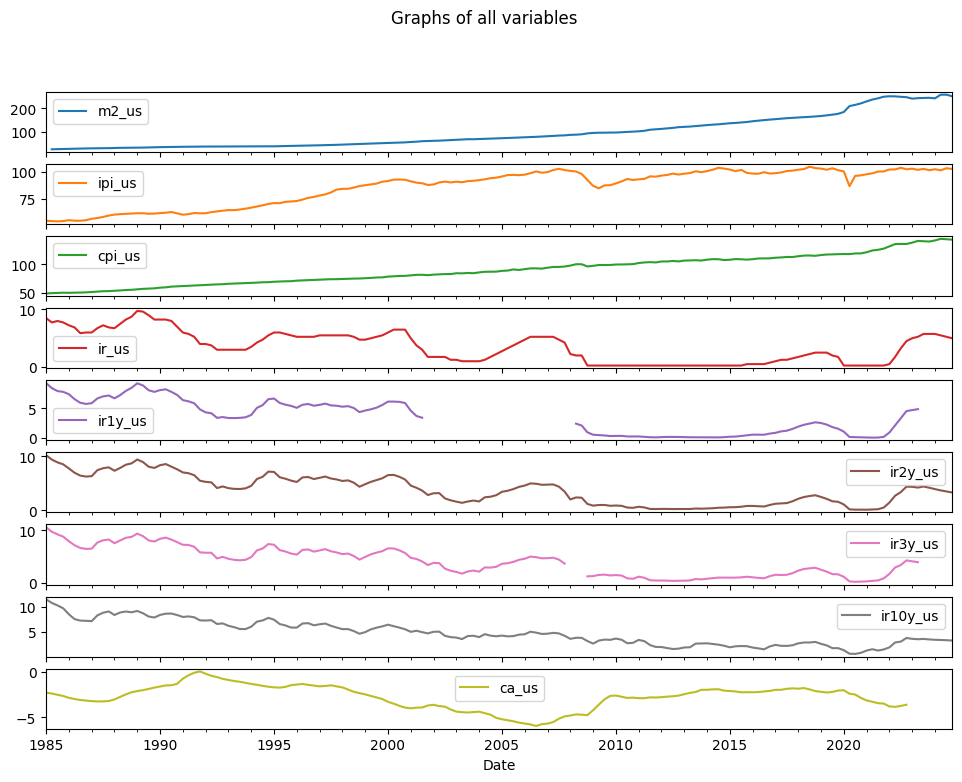

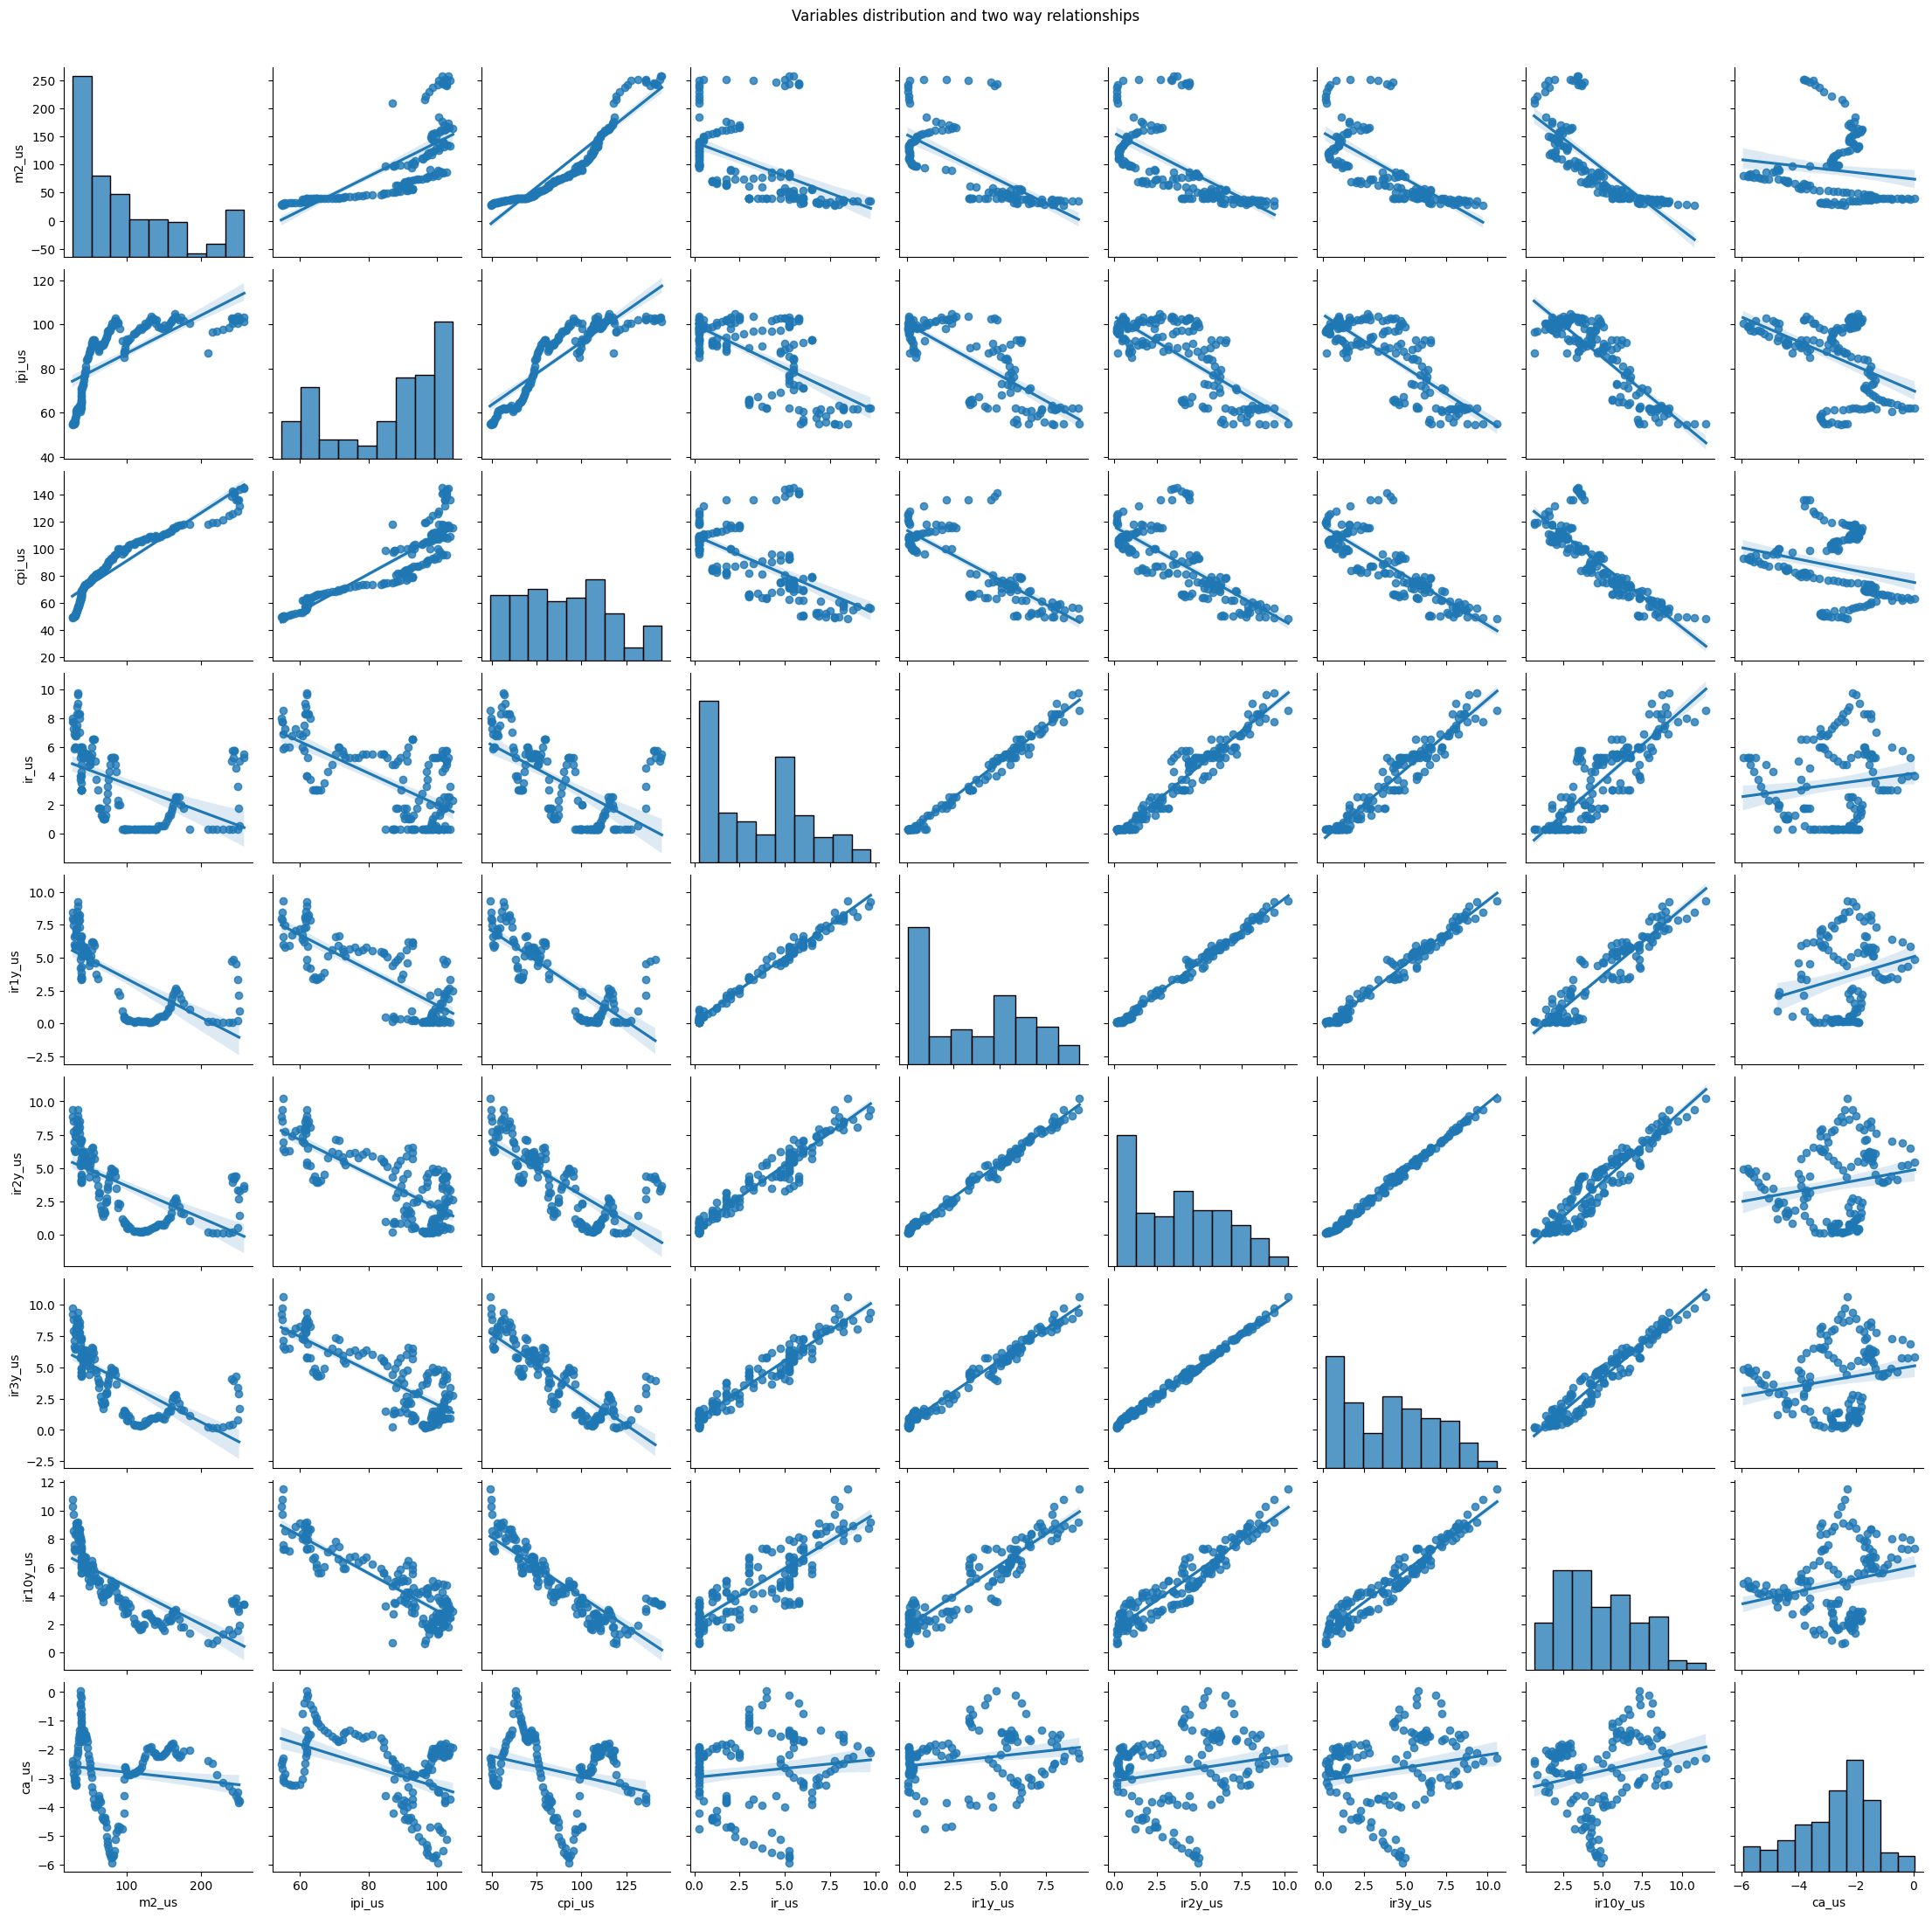

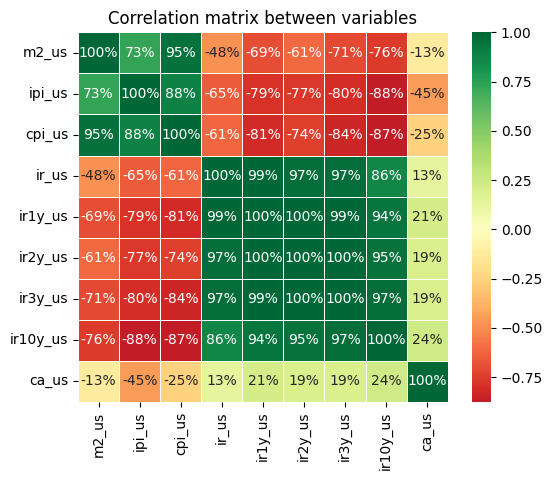

In [ ]:
#code to show exploratory data analysis

eda(data)

In [ ]:
#code to create specific dataframe for testing purposes to ensure no changes to original dataframe

ols_df = pd.DataFrame(data[input('Please put the columns you want to use for this OLS model seperated by space: ').split(" ")].copy(deep = True)).loc[input('Please insert model sample start date in YYYY-MM-DD format '):input('Please insert model sample end date in YYYY-MM-DD format ')].dropna()

Please put the columns you want to use for this OLS model seperated by space: m2_us cpi_us ir10y_us ipi_us
Please insert model sample start date in YYYY-MM-DD format 1990-01
Please insert model sample end date in YYYY-MM-DD format 2023-06


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 1990-03-01 to 2023-06-01
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   m2_us     134 non-null    float64
 1   cpi_us    134 non-null    float64
 2   ir10y_us  134 non-null    float64
 3   ipi_us    134 non-null    float64
dtypes: float64(4)
memory usage: 5.2 KB
None




,m2_us,cpi_us,ir10y_us,ipi_us
Date,,,,
1990-03-01,36.863361,58.954621,8.413469,62.089667
1990-06-01,37.136072,59.504314,8.665538,62.396667
1990-09-01,37.608694,60.786932,8.687446,63.050233
1990-12-01,37.807450,61.290818,8.392924,61.787267
1991-03-01,38.386383,61.840511,8.012258,60.572200
1991-06-01,38.733049,62.298589,8.117554,61.080600
1991-09-01,38.767716,62.848282,7.945470,62.148900
1991-12-01,38.967627,63.168937,7.334803,61.846000
1992-03-01,39.333938,63.810246,7.296875,61.957567


,m2_us,cpi_us,ir10y_us,ipi_us
Date,,,,
2021-03-01,229.273676,121.334289,1.312202,97.765400
2021-06-01,236.963895,124.457922,1.579955,98.607333
2021-09-01,242.249403,125.655338,1.317730,100.232833
2021-12-01,249.014023,127.713023,1.528845,100.374400
2022-03-01,250.734644,131.699217,1.945875,102.161467
2022-06-01,250.368333,135.733509,2.924622,102.199500
2022-09-01,248.723978,135.961173,3.096858,103.748933
2022-12-01,246.804601,135.956134,3.815849,102.319667
2023-03-01,240.821137,138.264389,3.647702,102.870967




Data summary statistics


,m2_us,cpi_us,ir10y_us,ipi_us
count,134.000000,134.000000,134.000000,134.000000
mean,100.293003,92.922789,4.239228,89.556081
std,60.815579,20.536998,2.006317,13.115845
min,36.863361,58.954621,0.645314,60.572200
25%,48.590801,74.735403,2.519350,84.528650
50%,80.980142,92.943998,4.151907,93.108317
75%,136.775250,108.834719,5.879606,99.739692
max,250.734644,141.298582,8.687446,104.672133


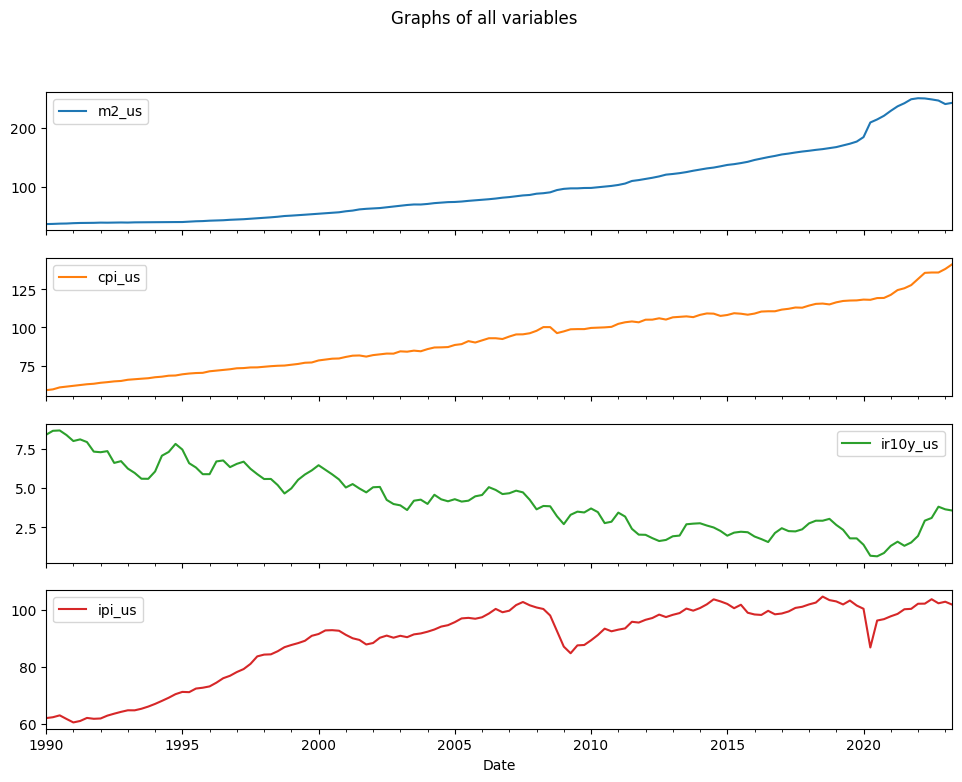

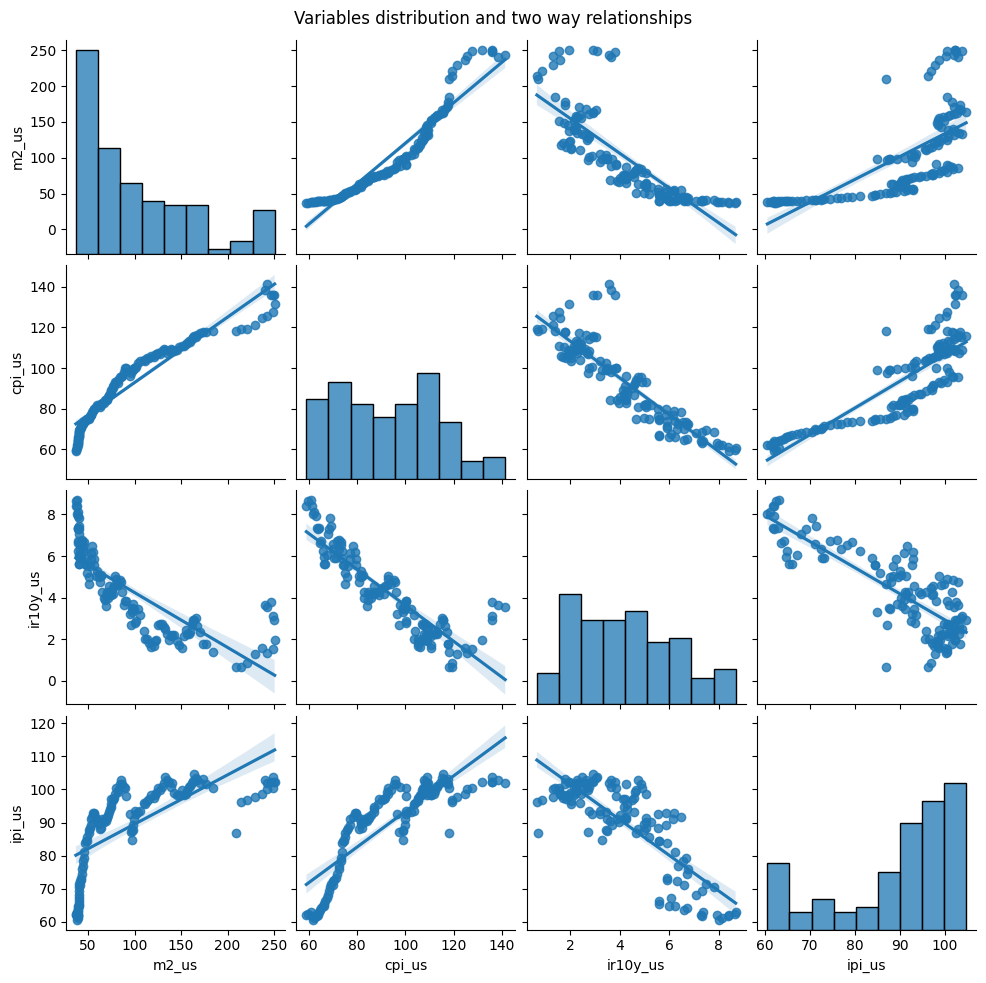

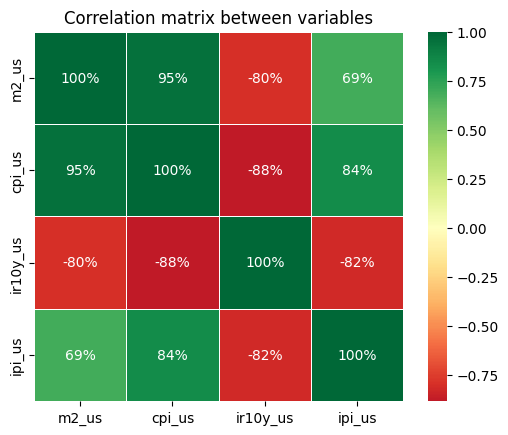

In [ ]:
#code for EDA

eda(ols_df)

Variables selection for the model
Enter columns to be used in model seperated by comma: ir10y_us,cpi_us,m2_us,ipi_us
Please put your dependent variable name: ir10y_us

Sample selection and sample transformation
Please insert model sample start date in YYYY-MM-DD format: 1990-01
Please insert model sample end date in YYYY-MM-DD format: 2023-06
1 if need to log, 0 if no need to log: 0
1 if need to diff, 0 if no need to diff: 0

Model parameter setting and fitting
Please put the formula of the ols, for example log brent linear model with balance and recession indicator as exogenous variables will have a formula such as 'np.log(brent) ~ balance + recession': np.log(ir10y_us) ~ m2_us + cpi_us


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)



Inversing model fitted value
1 if need to invert log, 0 if no need to invert log: 0
1 if need to invert diff, 0 if no need to invert diff: 0


                            OLS Regression Results                            
Dep. Variable:       np.log(ir10y_us)   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     22.09
Date:                Sat, 07 Oct 2023   Prob (F-statistic):           5.42e-09
Time:                        14:45:51   Log-Likelihood:                -27.204
No. Observations:                 134   AIC:                             60.41
Df Residuals:                     131   BIC:                             69.10
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025

,10%,5%,1%
0,0.000000,0.000000,0.000000




OLS model with constant (read: intercept) is considered to have an expected residual mean of zero thus passing the assumption that residuals have a population mean of zero


Still has not found test for endogeneity - to be updated


Ljung-Box test for serial correlation: H0 is no serial correlation up to lag 24


,10%,5%,1%
0,0.000000,0.000000,0.000000




Breusch-Pagan Lagrange Multiplier test for heteroscedasticity: H0 is that the error variances are all equal, homoscedastic


,10%,5%,1%
0,0.000000,0.000000,0.000000




Variance Inflation Factor test for perfect linearity between explanatory variables: if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables


,VIF
Intercept,101.007915
m2_us,11.080870
cpi_us,11.080870




Jarque Bera test for normality: H0 is standadised residual shows normality


,10%,5%,1%
0,0.000000,0.000000,0.000000


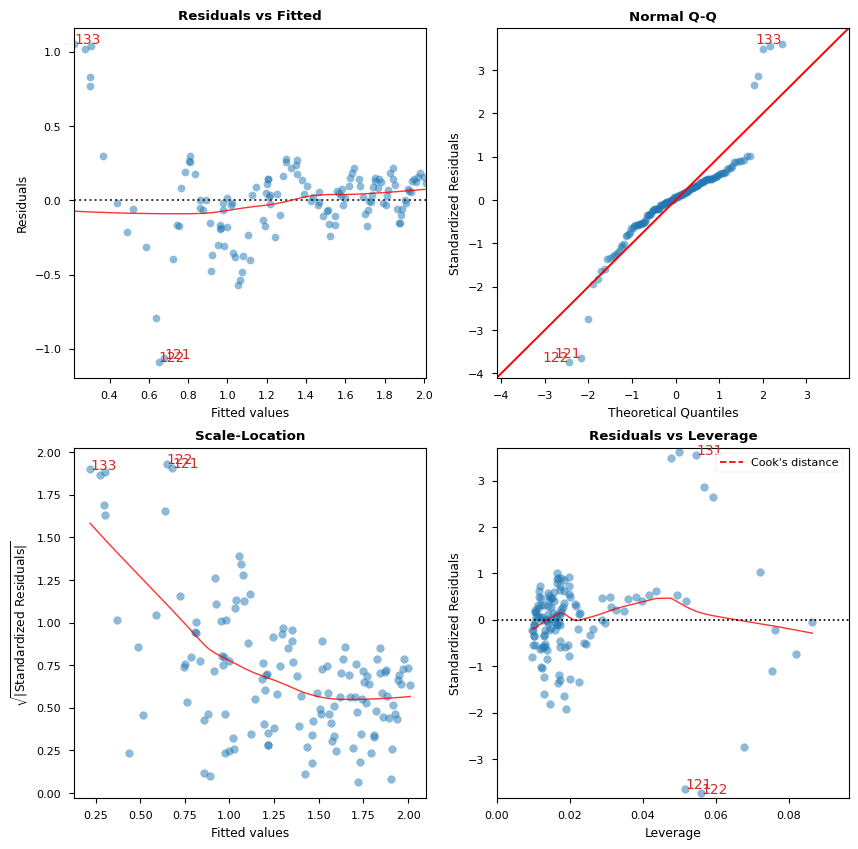





Enter the Y label name and unit ir10y_us/usd


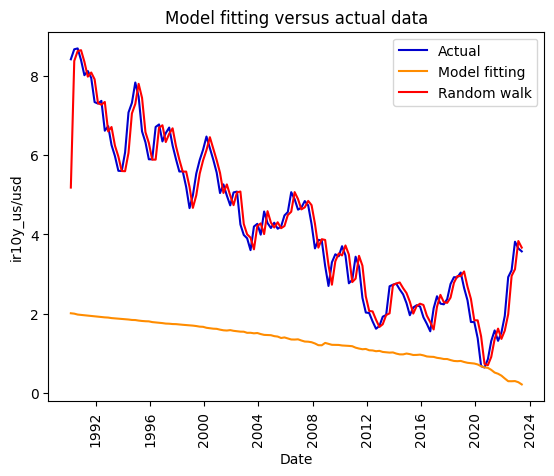



Please put model name: ols
Please put dependent variable name: ir10y_us
Forecast Accuracy of: ols  used to forecast  ir10y_us
mape   :  0.6524
me     :  -2.9264
mae    :  2.9265
mpe    :  -0.6523
rmse   :  3.3424
corr   :  0.8707
minmax :  0.6524
Please put dependent variable name: ir10y_us
Forecast Accuracy of: Random walk model  used to forecast  ir10y_us
mape   :  0.0952
me     :  0.0238
mae    :  0.3187
mpe    :  0.0208
rmse   :  0.4633
corr   :  0.973
minmax :  0.0845


In [ ]:
# code for OLS model fitting

model, fit, predict, residual, actual, formula = ols_model(data)

Please put the dependent variable name here: ir10y_us
Splitting dataset into train and test sets
Please put the desired size of your test data in decimal i.e. 20% put 0.2: 0.2

Sample transformation
1 if need to log, 0 if no need to log: 0
1 if need to diff, 0 if no need to diff: 0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)



Model parameter setting and fitting

Inversing model fitted value
1 if need to invert log, 0 if no need to invert log: 0
1 if need to invert diff, 0 if no need to invert diff: 0


Enter the Y label name and unit ir10y_us/usd


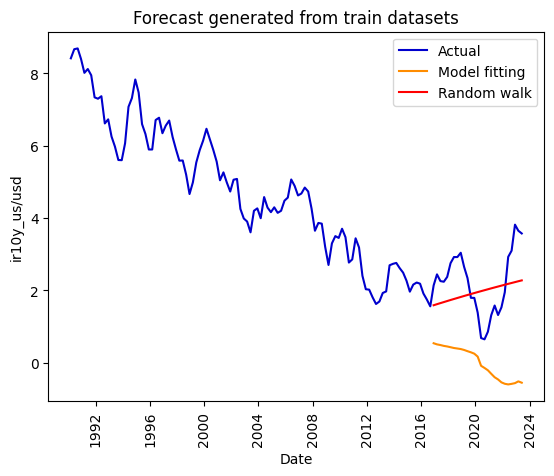



Please put model name: ir10y_us
Please put dependent variable name: ir10y_us
Forecast Accuracy of: ir10y_us  used to forecast  ir10y_us
mape   :  1.0231
me     :  -2.226
mae    :  2.226
mpe    :  -1.0231
rmse   :  2.4289
corr   :  -0.0112
minmax :  1.0231
Please put dependent variable name: ir10y_us
Forecast Accuracy of: Random walk model  used to forecast  ir10y_us
mape   :  0.4839
me     :  -0.2765
mae    :  0.8301
mpe    :  0.1014
rmse   :  0.9174
corr   :  0.0775
minmax :  0.3276
RMSE for Four Quarters Ahead (Model Fitting): 1.7730800663740898
RMSE for Four Quarters Ahead (Random Walk): 0.6457032359198124


In [ ]:
ols_simple_validation(actual, formula)